In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from sklearn.model_selection import train_test_split

import os
tf.logging.set_verbosity(tf.logging.INFO)

# Load data

In [2]:
filename = "../data/test_gemini_BTCUSD_Close_3H_LWS3_IWS20_TrfRP.npz"

In [3]:
Image_window_size = np.int(filename[filename.find('_IWS') + 4 : filename.find("_Trf")])
Image_window_size

20

In [4]:
data = np.load(filename)

In [5]:
images = data['images']
image_labels = data['image_labels']
label_names = data['label_names']

# Check data

In [6]:
# for quick check: only 1000 images
images = images[:1000]
image_labels = image_labels[:1000]

In [7]:
images.shape

(1000, 19, 19)

In [8]:
image_labels.shape

(1000, 3)

In [9]:
print("max: {}; min: {}".format(np.amax(images), np.amin(images)))

max: 1.0; min: 0.0


In [10]:
label_names = label_names.item()
label_names

{2: 'Sell', 0: 'Buy', 1: 'Hold'}

## e.g.:

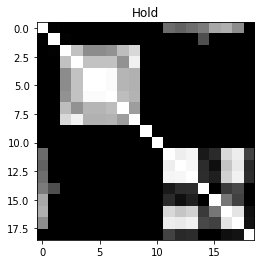

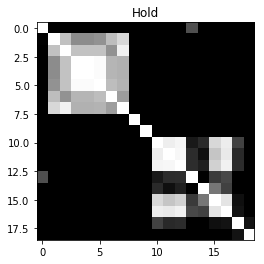

In [11]:
for idx, image in enumerate(images[:2]):
    plt.imshow(image, cmap = "Greys")
    plt.title(label_names[np.int(np.argwhere(image_labels[idx]))])
    plt.show()

# Train - test split without overlap

In [12]:
images_train, images_test, image_labels_train, image_labels_test = train_test_split(images, 
                                                                                    image_labels, 
                                                                                    test_size = .2, 
                                                                                    random_state = 22
                                                                                   )

## We need to get rid of the first (Image Window Size -1) test data to avoid lookahead bias.

In [13]:
images_test = images_test[(Image_window_size-1):]
image_labels_test = image_labels_test[(Image_window_size-1):]

In [14]:
print("Train images shape : {}; Train labels shape : {}".format(images_train.shape, image_labels_train.shape))

Train images shape : (800, 19, 19); Train labels shape : (800, 3)


In [15]:
print("Test images shape : {}; Test labels shape : {}".format(images_test.shape, image_labels_test.shape))

Test images shape : (181, 19, 19); Test labels shape : (181, 3)


# Reshape

In [16]:
images_test = images_test.reshape(-1, images_test.shape[1], images_test.shape[2] , 1)
images_train = images_train.reshape(-1, images_train.shape[1], images_train.shape[2] , 1)

In [17]:
print("Train images shape : {}; Train labels shape : {}".format(images_train.shape, image_labels_train.shape))

Train images shape : (800, 19, 19, 1); Train labels shape : (800, 3)


In [18]:
print("Test images shape : {}; Test labels shape : {}".format(images_test.shape, image_labels_test.shape))

Test images shape : (181, 19, 19, 1); Test labels shape : (181, 3)


# The Deep CNN

## Hyperparameter settings

In [19]:
training_iters = 200
learning_rate = 0.001
batch_size = 128

### Network Parameters

In [20]:
# image shape (d x d)
n_input = images_train.shape[1]

# number of classes
n_classes =  image_labels_train.shape[1]

# dropout
dropout = 0.8 # prob. to keep 

In [21]:
# placeholders float type
#input placeholder
x = tf.placeholder("float", [None, n_input, n_input, 1])

# output placeholder
y = tf.placeholder("float", [None, n_classes])

# dropout
keep_prob = tf.placeholder(tf.float32)

### Wrappers

Because using conv layer multiple times, we define it as a function (strides should be 1 for the first because it is the image number, the last should be one, because the gray scale image is only one channel)

In [22]:
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'SAME')

In [23]:
def avgpool2d(x, k = 2):
    return tf.nn.avg_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'SAME')

In [ ]:
def cnn_model_fn(x, y, mode):
    """Model function for CNN"""
    
    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs = x,
        filters = 32,
        kernel_size = [3, 3],
        padding = "SAME",
        activation = tf.nn.relu)
    
    # Pooling Layer #1
    pool1 = avgpool2d(conv1, k = 2)
    
    # Convolutional Layer #2
    conv2 = tf.layers.conv2d(
        inputs = pool1,
        filters = 64,
        kernel_size = [3, 3],
        padding = "SAME",
        activation = tf.nn.relu)
    
    # Pooling layer #2
    pool2 = avgpool2d(conv2, k = 2)
    
    # Convolutional Layer #3
    conv3 = tf.layers.conv2d(
        inputs = pool2,
        filters = 128,
        kernel_size = [3, 3],
        padding = "SAME",
        activation = tf.nn.relu)
    
    # Pooling layer #3
    pool3 = avgpool2d(conv3, k = 2)
    
    # Dense Layer
    pool3_flat = tf.reshape(pool3, [-1, ])

### Initialization of weights, biases

Xavier initialization: Xavier Glorot & Yoshua Bengio (2010), designed to keep the scale of the gradients roughly the same in all layers.

In [25]:
weights = {
    'wc1' : tf.get_variable('W0', shape = (3, 3, 1, 32), initializer=tf.contrib.layers.xavier_initializer()),
    'wc2' : tf.get_variable('W1', shape = (3, 3, 32, 64), initializer=tf.contrib.layers.xavier_initializer()),
    'wc3' : tf.get_variable('W2', shape = (3, 3, 64, 128), initializer=tf.contrib.layers.xavier_initializer()),
    'wd1' : tf.get_variable('W3', shape = (4*4*128, 128), initializer=tf.contrib.layers.xavier_initializer()),
    'out' : tf.get_variable('W4', shape = (128, n_classes), initializer=tf.contrib.layers.xavier_initializer())
}

biases = {
    'bc1' : tf.get_variable('B0', shape = (32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2' : tf.get_variable('B1', shape = (64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3' : tf.get_variable('B2', shape = (128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1' : tf.get_variable('B3', shape = (128), initializer=tf.contrib.layers.xavier_initializer()),
    'out' : tf.get_variable('B4', shape = (n_classes), initializer=tf.contrib.layers.xavier_initializer())
}


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


### Network Build

In [26]:
def conv_net(x, weights, biases, dropout):
    # here we call conv2d fct. and pass input image x, weights wc1, bias bc1
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Avg. pooling (down-sampling), this chooses the avg value of a 2*2 matrix window and outputs a 10*10 matrix (ceil(image_size/2))
    conv1 = avgpool2d(conv1, k = 2) # could be maxpooling
    
    # Convolution layer
    
    # call conv2d, pass input conv1, weights wc2, biases bc2
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Avg. pooling (down-sampling), this chooses the avg value of a 2*2 matrix window and outputs a ceil(conv1_len/2) * ceil(conv1_len/2)  matrix
    conv2 = avgpool2d(conv2, k = 2)
    
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Avg. pooling (down-sampling), this chooses the avg value of a 2*2 matrix window and outputs a ceil(conv2_len/2)*ceil(conv2_len/2) matrix
    conv3 = avgpool2d(conv3, k = 2)
    
    
    # Fully Connected Layer (Dense)
    # REshape conv3 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    
     # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)
    
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and bias term for the out
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    
    return out

### Loss and Optimizer Nodes

Loss funciton here is cross entropy, with the reasoning that it's a fitting loss function due to always being positive and tending towards zero if the neuron gets better in guessing the right label and because it recovers faster from wrong intializations and the learning doesnt slow down

Avg. loss over batches to get a  single loss - maybe weighted

In [27]:
pred = conv_net(x, weights, biases, keep_prob)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = pred, labels = y))

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Evaluate Model Node

U can save a graph and run testing on it later

ACCURACY CAN BE CHANGED TO OTHER MEASURE LATER

In [28]:
# Check wether the index of the maximum value of the predicted image is equal to the actual labelled image - both will be a column vector
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

# Calculate accuracy across all given images and average them
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [29]:
# Initializing the vars
init = tf.global_variables_initializer()

## Training and testing

In [30]:
np.int(np.ceil(len(images_train)/batch_size))

7

In [31]:
for batch in range(np.int(np.ceil(len(images_train)/batch_size))):
            batch_x = images_train[batch*batch_size:min((batch+1)*batch_size, len(images_train))]
            batch_y = image_labels_train[batch*batch_size:min((batch+1)*batch_size, len(image_labels_train))]
            
            print(batch_x.shape, batch_y.shape)

(128, 19, 19, 1) (128, 3)
(128, 19, 19, 1) (128, 3)
(128, 19, 19, 1) (128, 3)
(128, 19, 19, 1) (128, 3)
(128, 19, 19, 1) (128, 3)
(128, 19, 19, 1) (128, 3)
(32, 19, 19, 1) (32, 3)


In [33]:
with tf.Session() as sess:
    sess.run(init)
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for i in range(training_iters):
        for batch in range(np.int(np.ceil(len(images_train)/batch_size))):
            batch_x = images_train[batch*batch_size : min((batch+1)*batch_size, len(images_train))]
            batch_y = image_labels_train[batch*batch_size : min((batch+1)*batch_size, len(image_labels_train))]
            
            # Run optimization op (backprop)
            # Calculate batch loss and accuracy
            sess.run(optimizer, feed_dict = {x : batch_x, y : batch_y, keep_prob: dropout})
            
            loss, acc = sess.run([cost, accuracy], feed_dict = {x : batch_x,
                                                                y : batch_y,
                                                                keep_prob: 1.})
        print("Iter " + str(i) + ", Loss = " + \
              "{:.6f}".format(loss) + ", Training Accuracy = " + \
              "{:.5f}".format(acc)
             )
        print('Optimization Finished!')

        # Calculate accuracy for all test images
        test_acc, valid_loss = sess.run([accuracy, cost], feed_dict = {x : images_test,
                                                                       y : image_labels_test})
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print('Testing Accuracy: ', "{:.5f}".format(test_acc))
    summary_writer.close()

InvalidArgumentError: logits and labels must be broadcastable: logits_size=[72,3] labels_size=[128,3]
	 [[node softmax_cross_entropy_with_logits (defined at <ipython-input-27-0aafd0515c66>:3) ]]

Caused by op 'softmax_cross_entropy_with_logits', defined at:
  File "C:\Users\Corvinus\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Corvinus\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Corvinus\Anaconda3\lib\asyncio\base_events.py", line 528, in run_forever
    self._run_once()
  File "C:\Users\Corvinus\Anaconda3\lib\asyncio\base_events.py", line 1764, in _run_once
    handle._run()
  File "C:\Users\Corvinus\Anaconda3\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\tornado\gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\tornado\gen.py", line 1080, in __init__
    self.run()
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-0aafd0515c66>", line 3, in <module>
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = pred, labels = y))
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 2471, in softmax_cross_entropy_with_logits_v2_helper
    precise_logits, labels, name=name)
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 9669, in softmax_cross_entropy_with_logits
    name=name)
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\Users\Corvinus\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): logits and labels must be broadcastable: logits_size=[72,3] labels_size=[128,3]
	 [[node softmax_cross_entropy_with_logits (defined at <ipython-input-27-0aafd0515c66>:3) ]]
